In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.data import Dataset

import tensorflow as tf

import statsmodels.api as sm

from hyperas import optim
from hyperopt import Trials, tpe


from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import STATUS_OK

In [2]:
df = pd.read_csv("model_data.csv")
df.drop(["Date", "Unnamed: 0"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27140 entries, 0 to 27139
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              27140 non-null  float64
 1   dewp              27140 non-null  float64
 2   slp               27140 non-null  float64
 3   visib             27140 non-null  float64
 4   wdsp              27140 non-null  float64
 5   max               27140 non-null  float64
 6   min               27140 non-null  float64
 7   fog               27140 non-null  float64
 8   rain_drizzle      27140 non-null  float64
 9   snow_ice_pellets  27140 non-null  float64
 10  hail              27140 non-null  float64
 11  thunder           27140 non-null  float64
 12  year sin          27140 non-null  float64
 13  year cos          27140 non-null  float64
dtypes: float64(14)
memory usage: 2.9 MB


In [3]:
# df = df.diff(periods=180).dropna().reset_index().drop("index", axis=1)
# df

In [4]:
# Train, Validation, Test Split
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]


In [5]:
scaler = StandardScaler()
scaler.fit(train_df)


StandardScaler()

In [6]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [7]:
# Various window parameters
input_width = 6
label_width = 6
shift = 1
label_columns = None

In [8]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

In [9]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns is not None:
        labels = tf.stack(
            [labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [10]:
# Examples for testing
example_window = tf.stack([np.array(train_scaled[:window_size]),
                        np.array(train_scaled[100:100+window_size]),
                        np.array(train_scaled[200:200+window_size])])
example_inputs, example_labels = split_window(example_window)



In [11]:
example_labels.shape

TensorShape([3, 6, 14])

In [12]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [13]:
def compile_fit(model, train, val, patience=2, max_epochs=10, optimizer="adam"):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs, validation_data = val, callbacks=[e_stop])
    return history

In [14]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)


In [15]:
def data():
    return model_train, model_val

In [16]:
def make_models(lstm_size, dense_size, dense_layer_num, activation, optimizer):

    model = Sequential()
    model.add(LSTM(lstm_size, return_sequences=True))
    for i in range(dense_layer_num):
        model.add(Dense(units=dense_size, activation=activation))
    model.add(Dense(14))

    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(model_train, epochs=15, validation_data=model_val, callbacks=[e_stop])

    return {"loss": np.amin(history.history["val_loss"]), "status": STATUS_OK, "model":model}

In [17]:
histories = []
lstm_sizes = [16, 64]
dense_sizes = [50, 200]
dense_layers = [0, 1, 2]
activations = ["relu"]
optimizers = ["adam"]
for lstm_size in lstm_sizes:
    for dense_size in dense_sizes:
        for dense_layer_num in dense_layers:
            for activation in activations:
                for optimizer in optimizers:
                    histories.append(make_models(lstm_size=lstm_size,
                                            dense_size=dense_size,
                                            dense_layer_num=dense_layer_num,
                                            activation=activation,
                                            optimizer=optimizer))
        

Epoch 1/15
594/594 [==============================] - 5s 8ms/step - loss: 0.6422 - mean_absolute_error: 0.5186 - val_loss: 0.3599 - val_mean_absolute_error: 0.3867
Epoch 2/15
594/594 [==============================] - 4s 7ms/step - loss: 0.4877 - mean_absolute_error: 0.4011 - val_loss: 0.3183 - val_mean_absolute_error: 0.3426
Epoch 3/15
594/594 [==============================] - 4s 7ms/step - loss: 0.4619 - mean_absolute_error: 0.3754 - val_loss: 0.3057 - val_mean_absolute_error: 0.3270
Epoch 4/15
594/594 [==============================] - 4s 7ms/step - loss: 0.4525 - mean_absolute_error: 0.3652 - val_loss: 0.3008 - val_mean_absolute_error: 0.3204
Epoch 5/15
594/594 [==============================] - 4s 7ms/step - loss: 0.4474 - mean_absolute_error: 0.3596 - val_loss: 0.2981 - val_mean_absolute_error: 0.3161
Epoch 6/15
594/594 [==============================] - 4s 7ms/step - loss: 0.4443 - mean_absolute_error: 0.3565 - val_loss: 0.2960 - val_mean_absolute_error: 0.3135
Epoch 7/15
594/5

KeyboardInterrupt: 

In [19]:
losses = []
for hist in histories:
    losses.append(hist["loss"])
losses

[0.289702445268631]

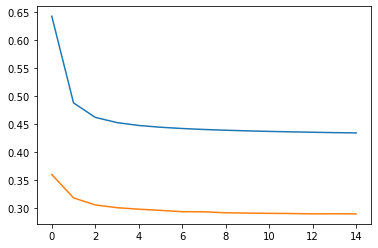

In [20]:
test_model = histories[0]["model"]
plt.plot(test_model.history.history["loss"], label="train")
plt.plot(test_model.history.history["val_loss"], label="test")
plt.show()

In [21]:
predictions = histories[0]["model"].predict(model_test)
predictions = scaler.inverse_transform(predictions)

In [22]:
pred_reshape = predictions.reshape((-1,14))

In [23]:
output_df = pd.DataFrame(predictions[:,5,:], columns=df.columns)
output_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,59.032234,44.936314,1021.706482,9.406876,6.990819,73.145943,47.487686,0.161327,0.068302,0.003053,0.000269,-0.017235,0.610206,-0.867711
1,52.318989,43.180656,1018.081177,8.363549,5.753158,64.947372,42.185829,0.482145,0.345533,0.012955,0.001372,0.061130,0.275054,-0.927072
2,52.209072,41.774319,1019.927307,7.308178,5.757918,64.113167,42.562119,0.589121,0.305609,0.005489,0.000161,-0.001555,-0.525154,-0.754737
3,69.470871,59.872334,1012.096985,12.262966,8.775221,79.718643,61.933022,0.182122,0.479340,-0.003528,0.000592,0.259972,1.015738,-0.334828
4,67.949066,58.812626,1013.841797,9.839282,8.933574,79.454781,59.248211,0.356730,0.297828,0.001211,0.001213,0.105452,0.382849,-0.890560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,76.953011,68.600243,1011.502075,10.217638,8.812281,84.998497,70.935471,0.237661,0.581831,-0.000456,0.002983,0.329493,-0.631360,0.774431
2704,83.597176,71.930046,1017.225342,10.225947,5.129978,94.262306,74.109558,0.140080,0.127504,-0.003392,0.000753,0.138879,-0.154108,1.007702
2705,84.271576,73.200050,1013.544617,10.002051,3.777609,96.079964,74.341621,0.179974,0.180654,-0.004525,0.000573,0.219933,0.793625,0.575441
2706,76.825523,65.814407,1013.767273,9.377647,5.996197,88.044891,66.719795,0.224979,0.152356,-0.003778,0.002242,0.110072,-0.710247,0.706134


In [30]:
resid = output_df["temp"] - test_df[6:].reset_index(drop=True)["temp"]
resid

0      -14.207766
1      -20.861011
2      -17.550928
3       -0.549129
4       -4.010934
          ...    
2703     5.113011
2704    10.237176
2705    11.491576
2706     4.025523
2707    -6.944233
Name: temp, Length: 2708, dtype: float64

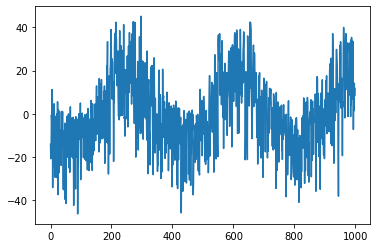

In [32]:
plt.plot(resid[:1000])

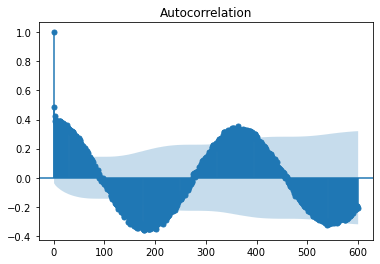

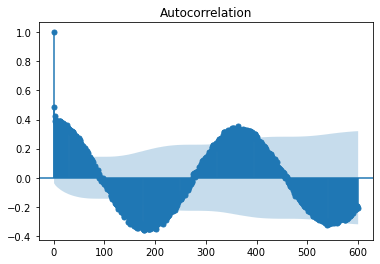

In [36]:
sm.graphics.tsa.plot_acf(resid, lags=600)

In [66]:
output_df

,temp,dewp,slp,visib,wdsp,max,min,fog,rain_drizzle,snow_ice_pellets,hail,thunder,year sin,year cos
0,64.255913,55.109035,1023.543640,9.150356,6.918299,75.307350,55.179470,0.469226,0.242021,-0.001990,-0.000887,-0.000933,-0.676173,-0.595225
1,64.599083,57.186459,1013.136597,8.530231,9.642522,74.165390,57.358845,0.519844,0.494727,-0.000853,0.001564,0.119819,-0.689716,-0.607996
2,59.271549,47.810291,1014.492615,10.254975,8.227999,70.426880,50.554691,0.389851,0.421766,-0.004533,0.000557,0.090563,-0.713563,-0.724608
3,60.830818,46.711349,1016.266113,11.066504,6.671521,74.036118,49.744133,0.281094,0.197447,-0.001586,-0.000473,0.014244,-0.637331,-0.628885
4,58.167248,39.602310,1022.752197,11.044800,6.141978,72.650085,45.891346,0.099188,0.040313,-0.007553,-0.001389,-0.034693,-0.777349,-0.615297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16243,69.950699,58.297314,1012.869507,10.366681,7.145612,80.381348,61.220440,0.199757,0.313742,0.004699,0.002225,0.179224,-0.823976,0.501299
16244,72.585365,61.620689,1018.291565,10.030954,5.314332,84.103691,62.493248,0.180162,0.081023,0.000620,0.000973,0.068031,-0.844810,0.404381
16245,74.121010,63.948448,1012.937378,9.620601,7.525266,84.166122,65.482841,0.201886,0.183213,0.000659,0.002641,0.098374,-0.915363,0.491330
16246,72.210587,63.816483,1013.982422,9.382206,7.401495,81.914589,63.930466,0.235908,0.220949,0.001607,0.002476,0.100843,-0.896217,0.414081


In [62]:
test_df = test_df[23:].reset_index().drop(["index"], axis=1)
resid = output_df["temp"] - test_df[23:]["temp"]
resid

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
16243   NaN
16244   NaN
16245   NaN
16246   NaN
16247   NaN
Name: temp, Length: 16248, dtype: float64

In [65]:
test_df["temp"]

0       79.42
1       79.60
2       81.26
3       83.32
4       83.84
        ...  
2686    71.84
2687    73.36
2688    72.78
2689    72.80
2690    76.34
Name: temp, Length: 2691, dtype: float64